# StockMarketPrediction

## Data Manipulation

### Connecting to Database

In [1]:
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(create_table_sql, conn):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [2]:
conn = create_connection("normalized_ppg6.db")

In [3]:
def query_table(sql_query, connx=conn):
    testdf = execute_sql_statement(sql_query, connx)
    return(testdf)

### Creating Analytical Dataset

In [4]:
sql_statement = "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"
query_table(sql_statement)

[('AAPL_5Y',),
 ('AMZN_5Y',),
 ('Company',),
 ('FB_5Y',),
 ('GOOG_5Y',),
 ('HistoricalPrices',),
 ('NFLX_5Y',)]

In [5]:
sql_statement = """CREATE TABLE HistoricalPrices AS
SELECT * FROM
(SELECT 'AAPL' AS StockSymbol, * FROM AAPL_5Y
UNION ALL
SELECT 'AMZN' AS StockSymbol, * FROM AMZN_5Y
UNION ALL
SELECT 'FB' AS StockSymbol, * FROM FB_5Y
UNION ALL
SELECT 'GOOG' AS StockSymbol, * FROM GOOG_5Y
UNION ALL
SELECT 'NFLX' AS StockSymbol, * FROM NFLX_5Y);"""
create_table(sql_statement, conn)

table HistoricalPrices already exists


## Data Exploration

In [6]:
#Importing the Libraries
import numpy as np
from datetime import datetime
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from matplotlib.figure import Figure 
fig = Figure()

In [7]:
# Loading Analytical Dataset into a Dataframe

sql_statement = "SELECT * FROM HistoricalPrices;"
tbl_stocks = execute_sql_statement(sql_statement, conn)
stocks_df = pd.DataFrame(tbl_stocks, columns = ['StockSymbol','Date','Open','High','Low','Close','Adj Close','Volume'])

stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])
stocks_df.set_index('Date', inplace=True)

### Daily Returns

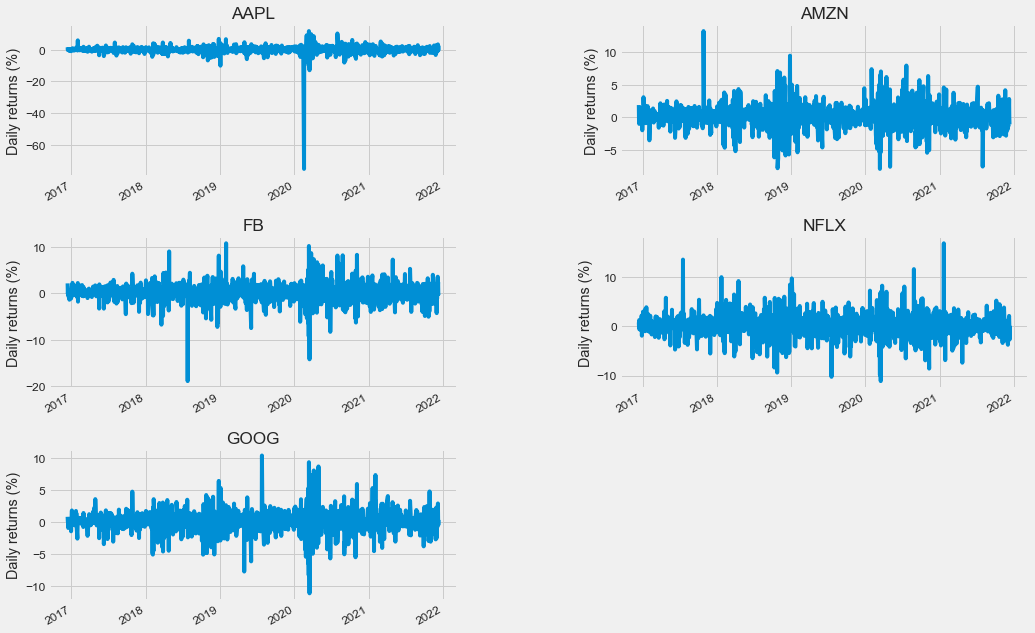

In [8]:
# Caluculate the daily returns for FAANG

returns_df = stocks_df.pivot_table(index=['Date'], columns='StockSymbol', values=['Close'])
returns_df.columns = [col[1] for col in returns_df.columns.values]
returns_df.head()

# Caluculate the percentage of daily returns

FAANG_daily_returns = returns_df.pct_change().dropna()
FAANG_daily_returns_pct = FAANG_daily_returns * 100

company_dict = {1:"AAPL", 2:"AMZN", 3:"FB", 4:"NFLX", 5:"GOOG"}

# plot the daily returns for FAANG
plt.rcParams.update({'font.size': 12})

for i, comp in company_dict.items():
    plt.subplot(3, 2, i)
    FAANG_daily_returns_pct[comp].plot(figsize=(17, 10))
    plt.ylabel('Daily returns (%)')
    plt.xlabel(None)
    plt.title(f"{comp}")

    
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

*After looking at the daily returns chart for all 5 companies. we can conclude that the returns are quite volatile and the stock can move about +/- 10% on any given day.*

### Cumulative Returns

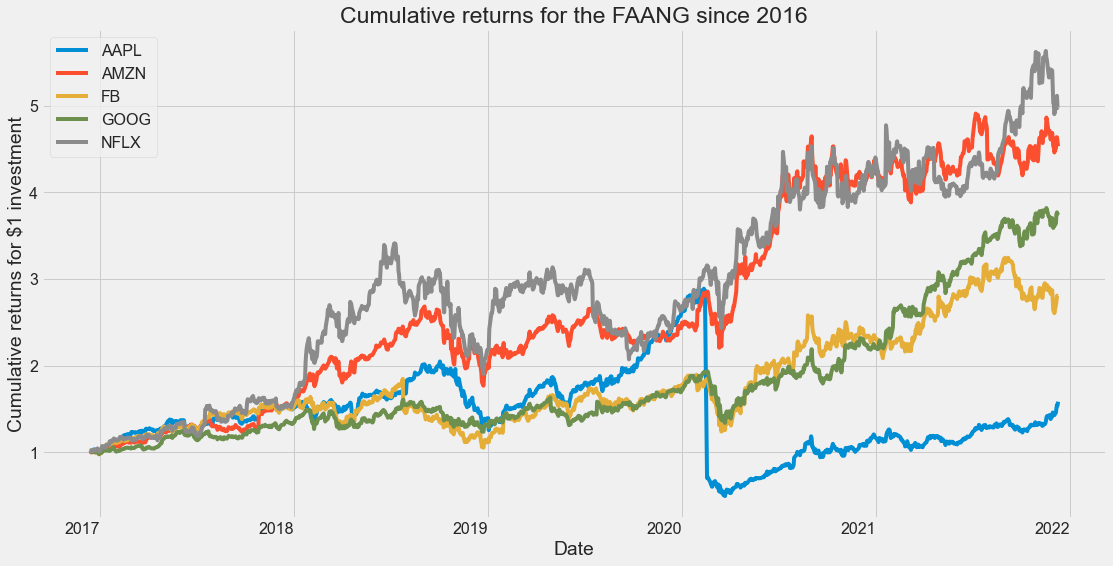

In [9]:
# Calculating the cumulative returns for the FAANG
FAANG_cum_returns = (FAANG_daily_returns + 1).cumprod()

plt.rcParams.update({'font.size': 16})
FAANG_cum_returns.plot(figsize=(17, 10))

plt.title("Cumulative returns for the FAANG since 2016")
plt.ylabel('Cumulative returns for $1 investment')
plt.xticks(rotation=0)

plt.show()

*This chart shows the cumulative returns since 2016 for FAANG. One could have made 6\\$ 𝑜𝑛 𝑎 1\\$ investment in Netflix since 2009. That is quite a remarkable performance.

Not surprisingly, Netflix has had the best returns since 2016. Amazon comes in second. The most surprising result is Apple. It has severely under performed compared to the other stocks in the FAANG group. Apple is currently undervalued and could be the better investment among the FAANG stocks.*

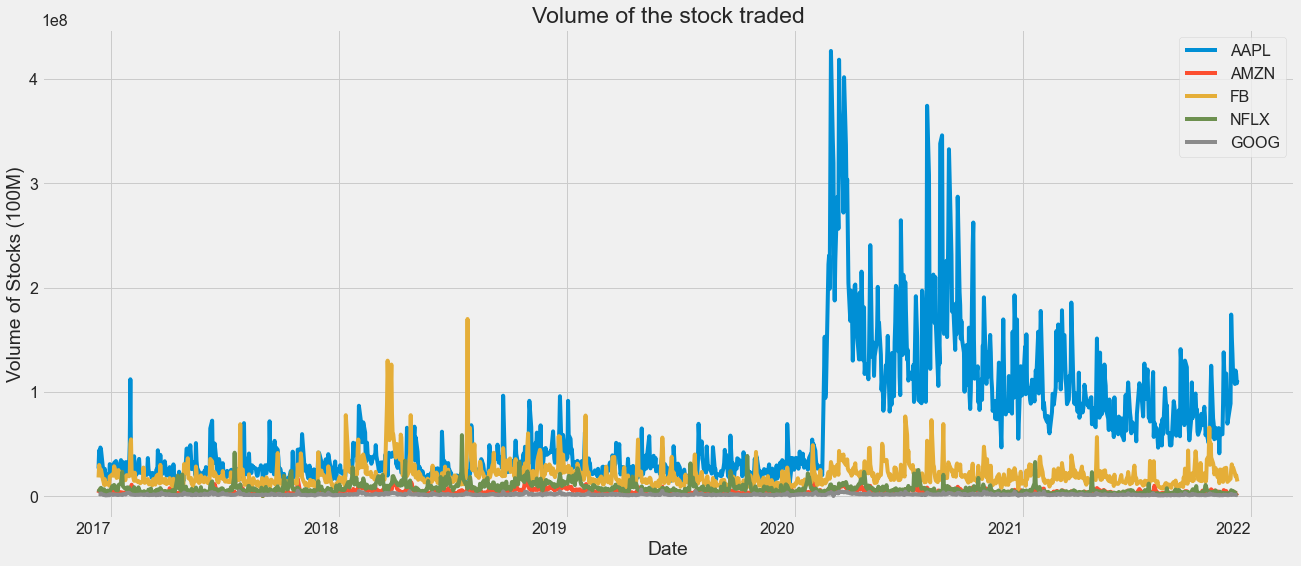

In [10]:
sql_statment = """SELECT tbl_aapl.Date as Date, AAPL, AMZN, FB, NFLX, GOOG  FROM (
(SELECT Date, Volume AS AAPL FROM HistoricalPrices WHERE StockSymbol = 'AAPL')tbl_aapl
INNER JOIN
(SELECT Date, Volume AS AMZN FROM HistoricalPrices WHERE StockSymbol = 'AMZN') tbl_amzn
ON tbl_aapl.Date = tbl_amzn.Date
INNER JOIN
(SELECT Date, Volume AS FB FROM HistoricalPrices WHERE StockSymbol = 'FB') tbl_fb
ON tbl_aapl.Date = tbl_fb.Date
INNER JOIN
(SELECT Date, Volume AS NFLX FROM HistoricalPrices WHERE StockSymbol = 'NFLX') tbl_nflx
ON tbl_aapl.Date = tbl_nflx.Date
INNER JOIN
(SELECT Date, Volume AS GOOG FROM HistoricalPrices WHERE StockSymbol = 'GOOG') tbl_goog
ON tbl_aapl.Date = tbl_goog.Date
)"""

tbl_volume = query_table(sql_statment)
Volume = pd.DataFrame(tbl_volume, columns = ['Date','AAPL','AMZN','FB','NFLX','GOOG'])
Volume['Date'] = pd.to_datetime(Volume['Date'])
Volume.set_index('Date', inplace=True)

plt.rcParams.update({'font.size': 16})

Volume.plot(figsize = (20,10))
plt.title(f"Volume of the stock traded")
plt.ylabel('Volume of Stocks (100M)')
plt.xticks(rotation=0)

plt.show()

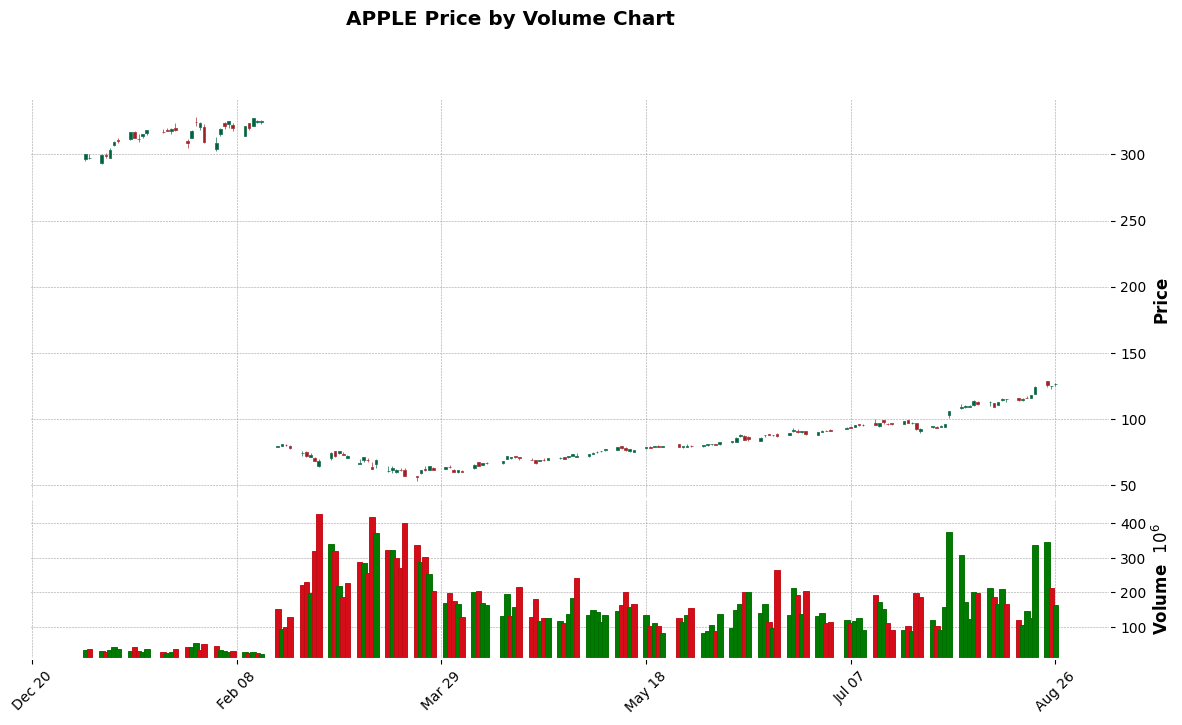

In [11]:
#Volume traded for Apple between Dec 2019 and Aug 2020
import mplfinance as mpf

df_AAPL = stocks_df[stocks_df['StockSymbol'] == 'AAPL']
dt_range = (datetime(2020,1,1), datetime(2020,8,26))

df_AAPL = pd.DataFrame(df_AAPL[dt_range[0]:dt_range[1]])
mpf.plot(df_AAPL, volume=True, type = 'candle', show_nontrading=True,
         style='charles', title='APPLE Price by Volume Chart', figsize = (15,8))

*Volume is the number of shares of a stock that have changed hands over a certain period of time. 
Stocks with higher volumes have more investors interested in buying or selling them. 
If a stock has a high volume and the price is rising, it's easier to sell it at a desirable price.*

*Trading volume can help an investor to identify momentum in stocks and confirm a trend. 
If trading volume increases, prices generally move in the same direction.*

**_The above Graph shows the volume traded by companies which clearly shows that stocks of Apple are traded more compared to other company stocks in recent years and in feb 2020 and 
it reached it's peak_**

C:\Users\iamh2k\AppData\Local\Temp/ipykernel_27896/2832431025.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company[column_name] = company['Adj Close'].rolling(ma).mean().dropna()


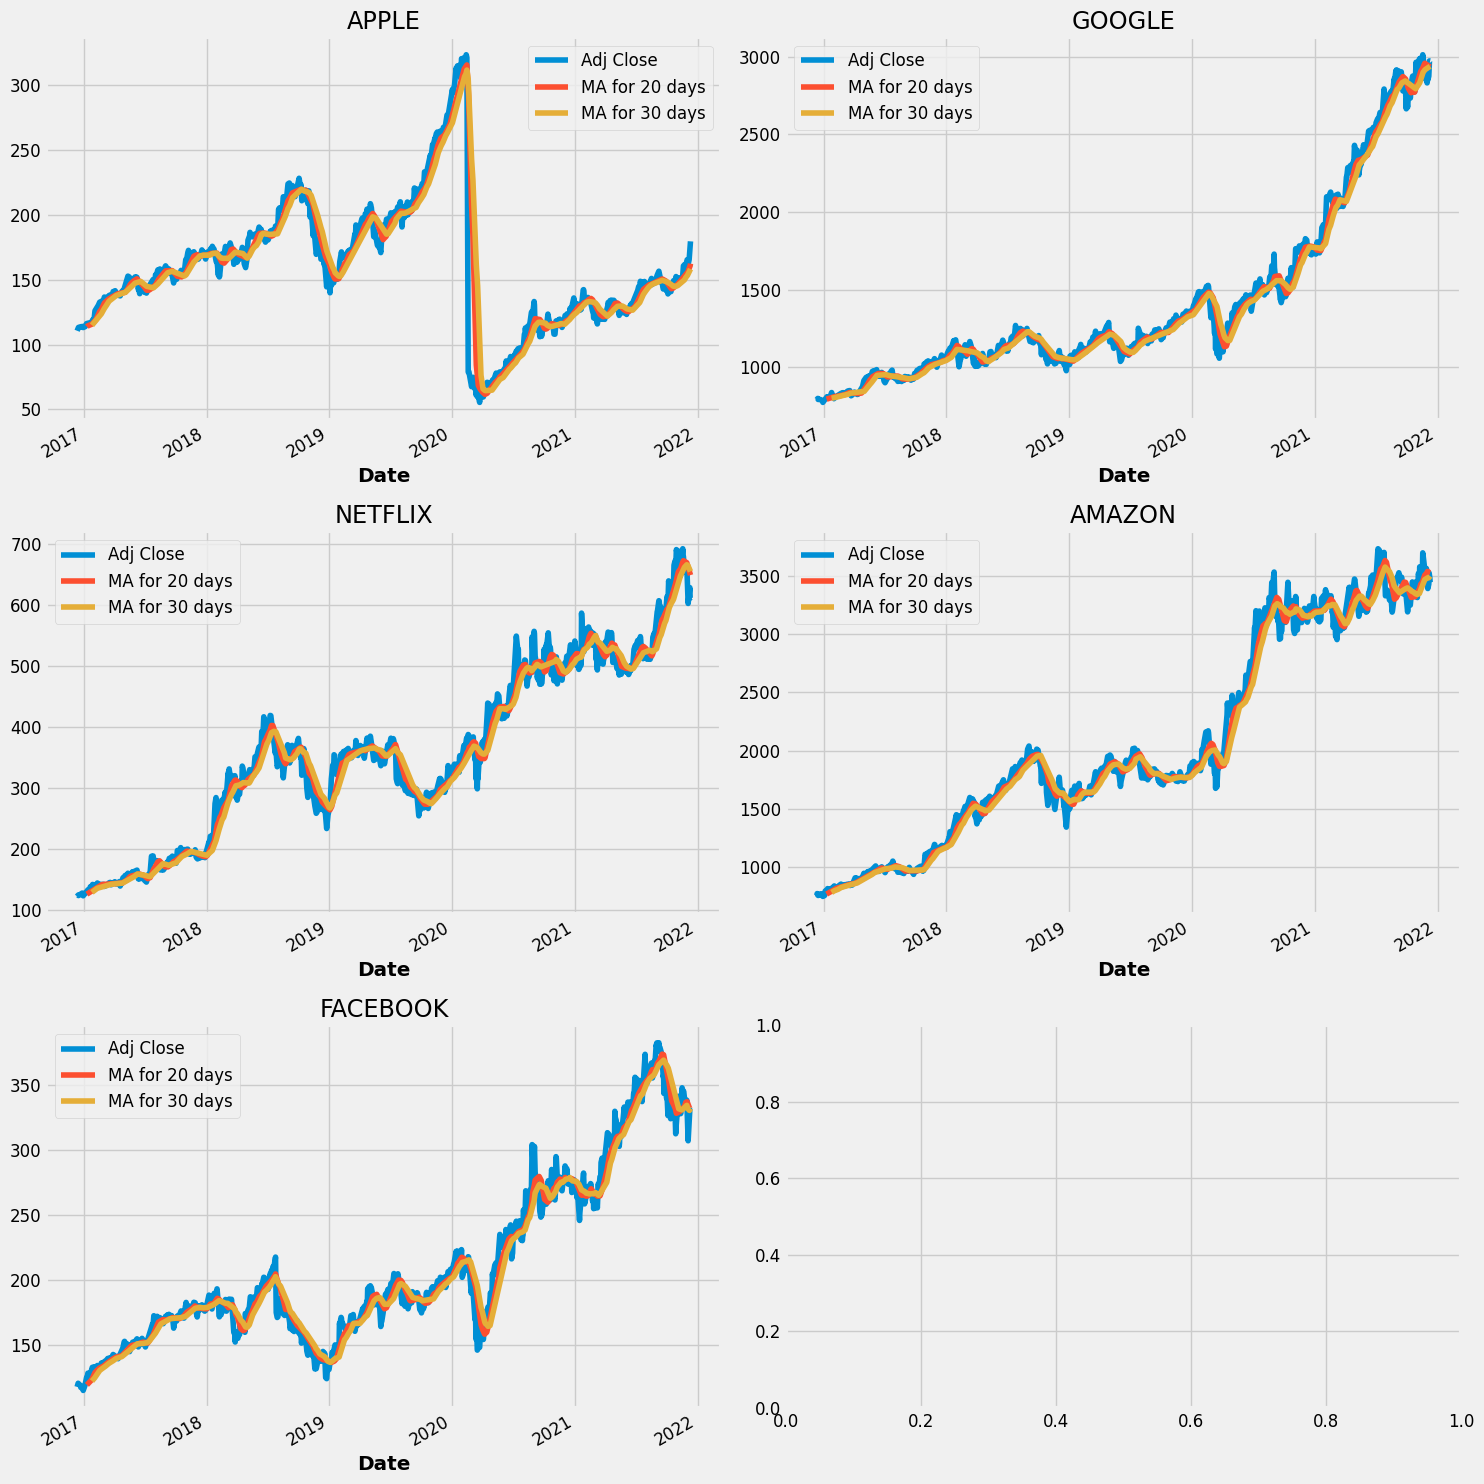

In [12]:
# The moving average of the various stocks

AdjClose = stocks_df[['StockSymbol', 'Adj Close']].copy()

for symbol in AdjClose.StockSymbol.unique():
    globals()[f'df_{symbol}'] = AdjClose[AdjClose['StockSymbol'] == symbol]

company_list = [df_AAPL, df_AMZN, df_FB, df_NFLX, df_GOOG]  

ma_days = [20, 30]
for company in company_list:
    for ma in ma_days:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean().dropna()

plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)

df_AAPL[['Adj Close', 'MA for 20 days', 'MA for 30 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

df_AMZN[['Adj Close', 'MA for 20 days', 'MA for 30 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

df_FB[['Adj Close', 'MA for 20 days', 'MA for 30 days']].plot(ax=axes[2,0])
axes[2,0].set_title('FACEBOOK')

df_NFLX[['Adj Close', 'MA for 20 days', 'MA for 30 days']].plot(ax=axes[1,0])
axes[1,0].set_title('NETFLIX')

df_GOOG[['Adj Close','MA for 20 days', 'MA for 30 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

fig.tight_layout()
plt.show()

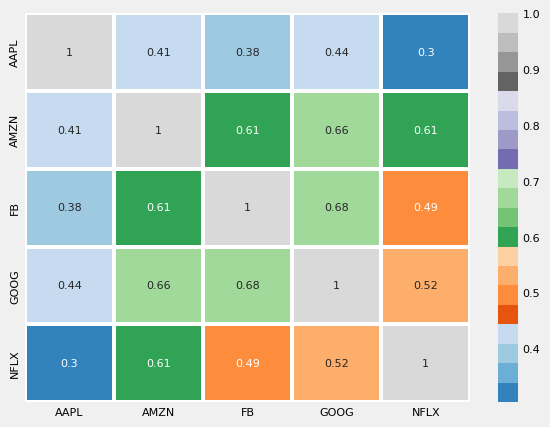

In [13]:
# Calculate the stock correlation matrix
import seaborn as sns

plt.rcParams.update({'font.size': 8})
sns.heatmap(FAANG_daily_returns.corr(), annot=True, cmap='tab20c', linewidths=1.5)
fig.tight_layout()

 4


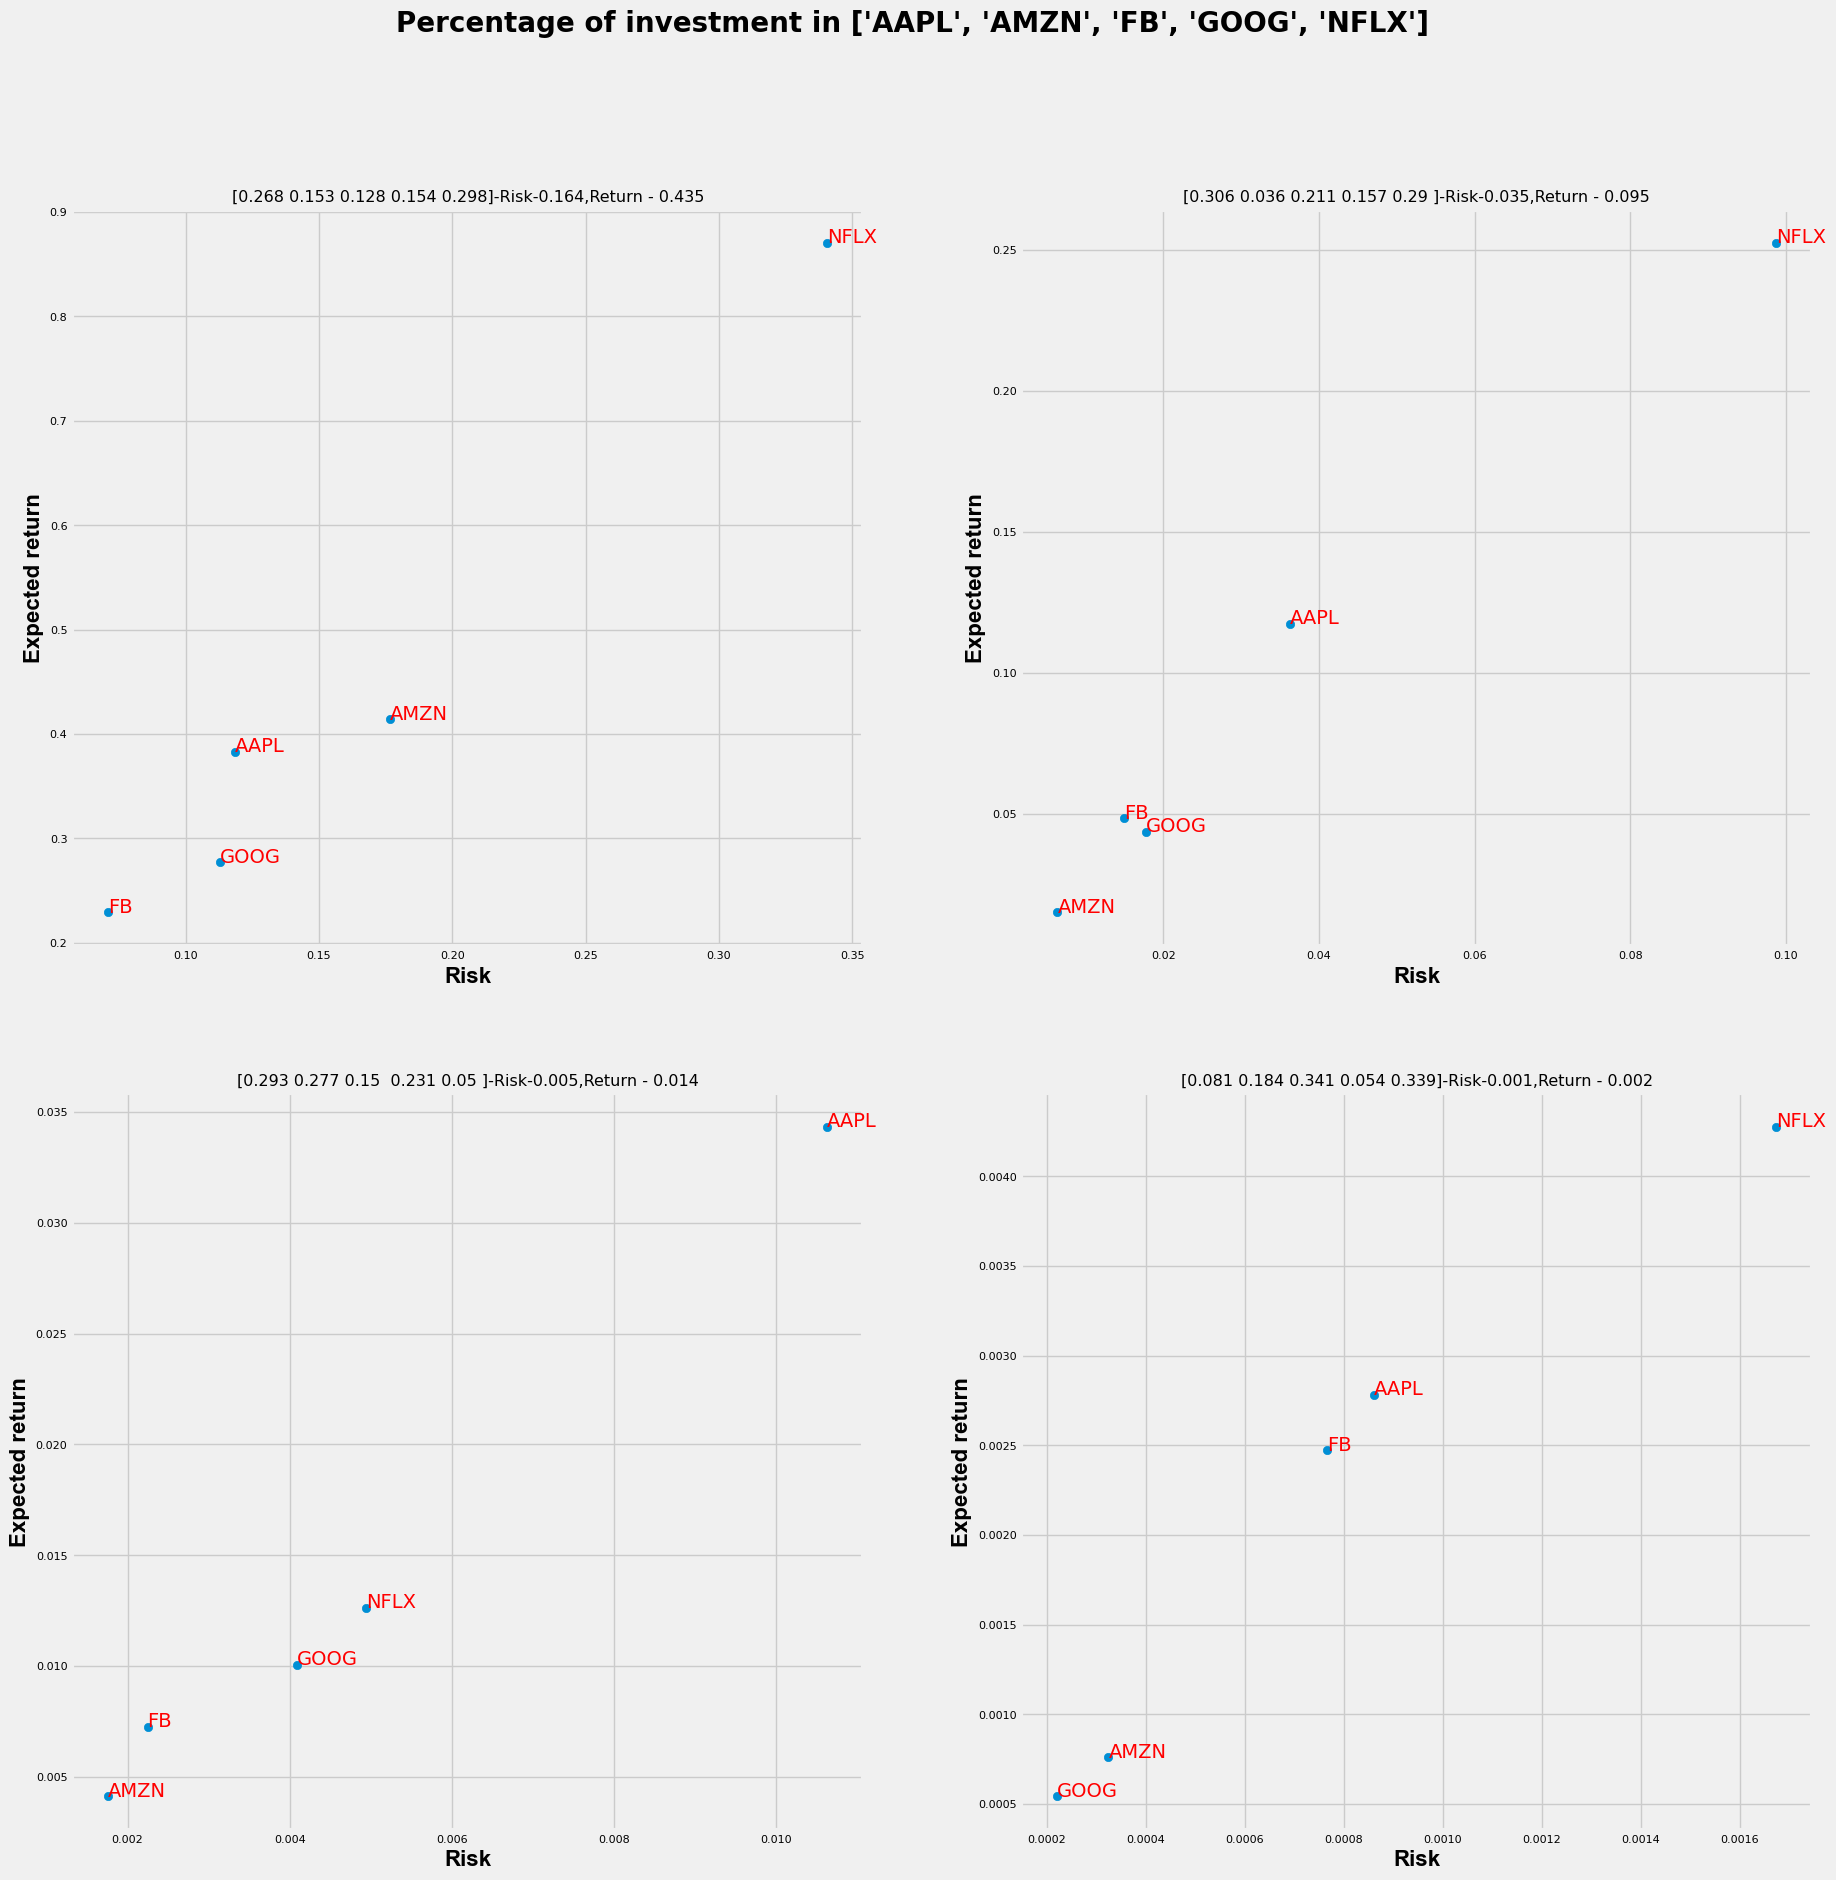

In [14]:
# Caluculating the Risk and Returns for Stocks with different percentages of investment

returns_val = returns_df/returns_df.iloc[0]
lis = list(returns_val.columns)
invest_list = []
no_of_sets = int(input())

# Add a way to user-provided percentage #hemanth
# Generating the random percentages of investment in FAANG
for i in range(no_of_sets):
    pct_investment = np.random.random(5)
    pct_investment /= pct_investment.sum()
    invest_list.append(pct_investment.round(3))

# plot the risk and returns of each portfolio
plt.subplots(figsize=(20,20))
XY_label = {'family': 'arial', 'color': 'black', 'size': 16}
plt.suptitle(f'Percentage of investment in {list(returns_val.columns)}',fontsize=20)

for i in range(no_of_sets):
    returns_val = returns_val * invest_list[i]
    plt.subplot(int((no_of_sets)/2),2,i+1)
    plt.scatter(returns_val.std(),returns_val.mean())
    plt.xlabel('Risk', fontdict = XY_label)
    plt.ylabel('Expected return',fontdict = XY_label)
    plt.title(f'{invest_list[i]}-Risk-{(((returns_val.std().sum())/5).round(3))},Return - {(((returns_val.mean().sum())/5).round(3))}')
    for i in range(5):
        plt.text(returns_val.std()[i],returns_val.mean()[i],returns_val.columns[i],color = 'red',size = 14)

## Time-Series Analysis

### Exploring Time Components

In [15]:
import os
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 10})
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

*For our time series analysis, we only need the close price at daily level. So for a particular chosen company (AMZN), we will run the detailed analysis. At the end of the analysis, we will functionalize the analysis to be easily applied for any chosen stock.*

In [16]:
tbl_close = query_table("""SELECT Date, Close FROM HistoricalPrices 
WHERE StockSymbol='AMZN' """)

df_close = pd.DataFrame(tbl_close, columns = ['Date','Close'])
df_close['Date'] = pd.to_datetime(df_close['Date'])
df_close.set_index('Date', inplace=True)
display(df_close)

,Close
Date,
2016-12-12,760.119995
2016-12-13,774.340027
2016-12-14,768.820007
2016-12-15,761.000000
2016-12-16,757.770020
...,...
2021-12-06,3427.370117
2021-12-07,3523.290039
2021-12-08,3523.159912


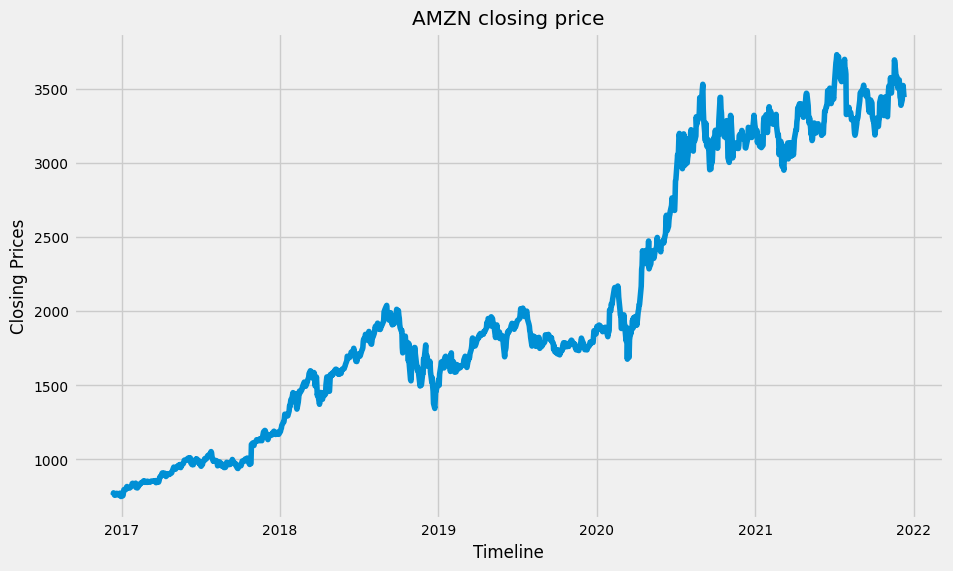

In [17]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(df_close['Close'])
plt.title('AMZN closing price')
plt.xlabel('Timeline')
plt.ylabel('Closing Prices')
plt.show()

<Figure size 1000x600 with 0 Axes>

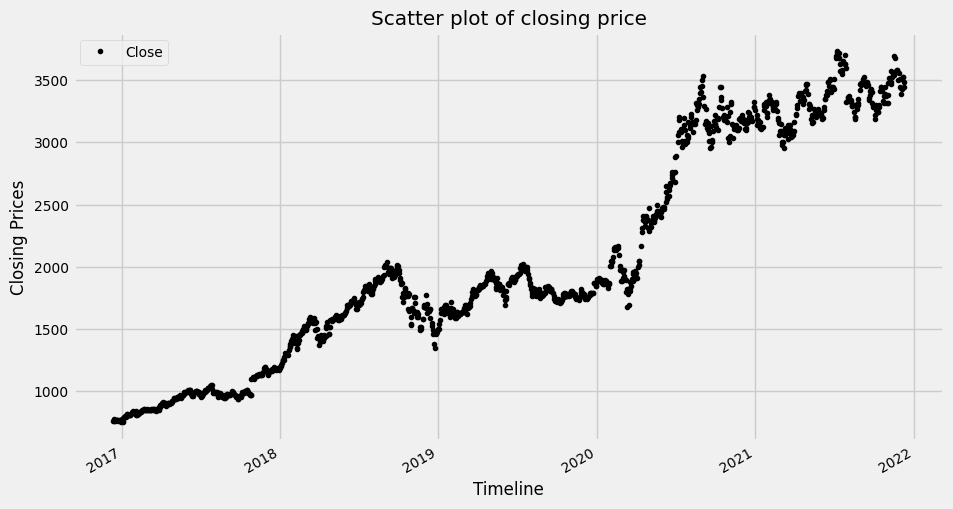

In [18]:
plt.figure(figsize=(10,6))
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.xlabel('Timeline')
plt.ylabel('Closing Prices')
plt.show()

<Figure size 1000x600 with 0 Axes>

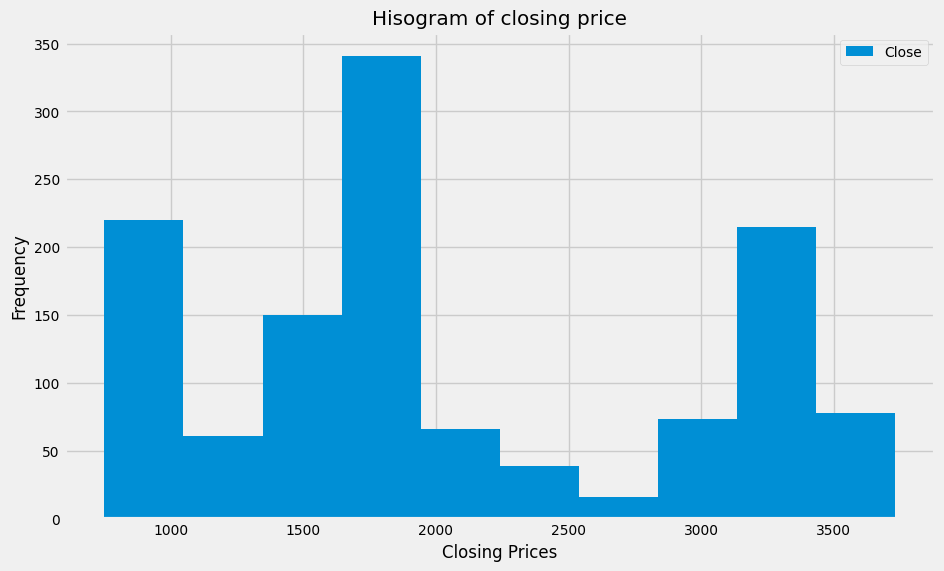

In [19]:
plt.figure(figsize=(10,6))
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.xlabel('Closing Prices')
plt.show()

#### Testing For Stationarity:

Ho: It is non-stationary
H1: It is stationary

> If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

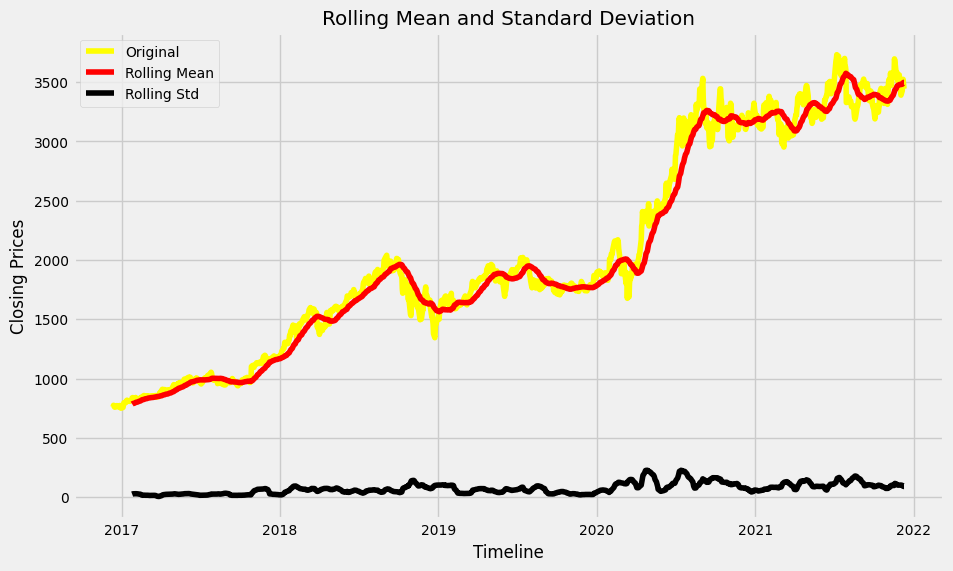

Results of dickey fuller test
Test Statistics                  -0.643743
p-value                           0.860788
No. of lags used                  3.000000
Number of observations used    1255.000000
critical value (1%)              -3.435571
critical value (5%)              -2.863846
critical value (10%)             -2.567998
dtype: float64


In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Timeline')
    plt.ylabel('Closing Prices')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close['Close'])

`Inference: p-value is greater than 0.05, so we cannot reject the Null hypothesis and the series is non-stationary`

To achieve stationarity, we will seperate Trend and Seasonality components from the time series

<Figure size 1000x600 with 0 Axes>

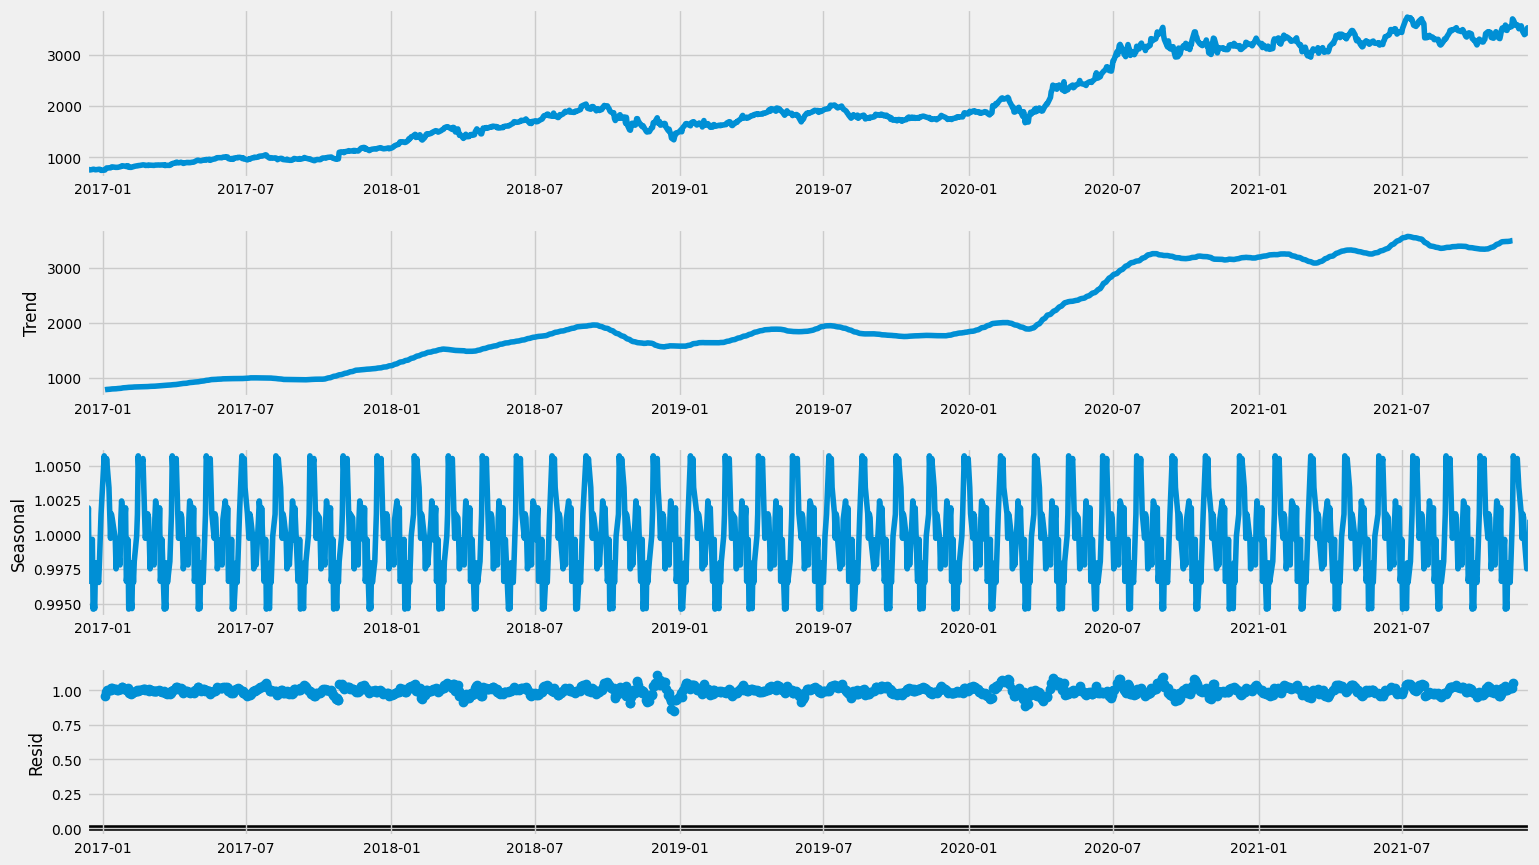

In [21]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

plt.show()

### ARIMA Modeling

#### Training:

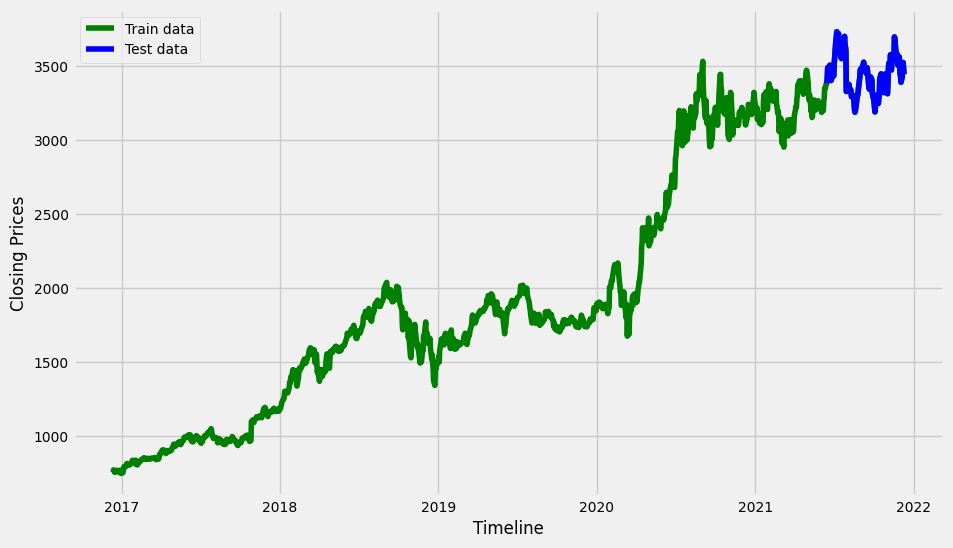

In [22]:
#split data into train and training set
split_ratio = 0.9
train_len = int(len(df_close)*split_ratio)
train_data, test_data = df_close[:train_len], df_close[train_len:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Timeline')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [23]:
def arimamodel(timeseries):
    automodel = auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf", # use adftest to find optimal 'd'
                              seasonal=False, # No Seasonality
                              trace=True)
    return automodel

In [24]:
def plot_arima(n_periods, timeseries, automodel, test_series=None, past_periods=None):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # Business Day index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="B")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    if past_periods:
        timeseries = timeseries[-past_periods:]
    plt.plot(timeseries, label="Past Data")
    if test_series is not None:
        plt.plot(test_series, color='blue', label='Actual Stock Price')
    plt.plot(fc_series, color='red', label ='Predicted Stock Price')
    plt.xlabel('Timeline')
    plt.ylabel('Closing Prices')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25,
                    label ="95% confidence interval")
    plt.legend(loc='upper left')
    plt.show()

In [25]:
def score_arima(n_periods, test_timeseries, automodel):
    fc = automodel.predict(n_periods=n_periods)
    
    mse = mean_squared_error(test_timeseries, fc)
    print(f'MSE: {mse} ({mse:.2%})')
    mae = mean_absolute_error(test_timeseries, fc)
    print(f'MAE: {mae} ({mae:.2%})')
    rmse = math.sqrt(mean_squared_error(test_timeseries, fc))
    print(f'RMSE: {rmse} ({rmse:.2%})')
    test_timeseries = test_timeseries.values
    mape = np.mean(np.abs(test_timeseries - fc)/np.abs(test_timeseries))
    print(f'MAPE: {mape} ({mape:.2%})')
    
    return None

In [26]:
automodel = arimamodel(train_data)
print(automodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11569.417, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11571.927, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11569.866, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11569.890, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11573.708, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11571.399, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11571.392, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11571.891, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11571.823, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11569.793, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11571.494, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.062 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

So the Auto ARIMA model provided the value of p,d, and q as 1, 1 and 1 respectively.

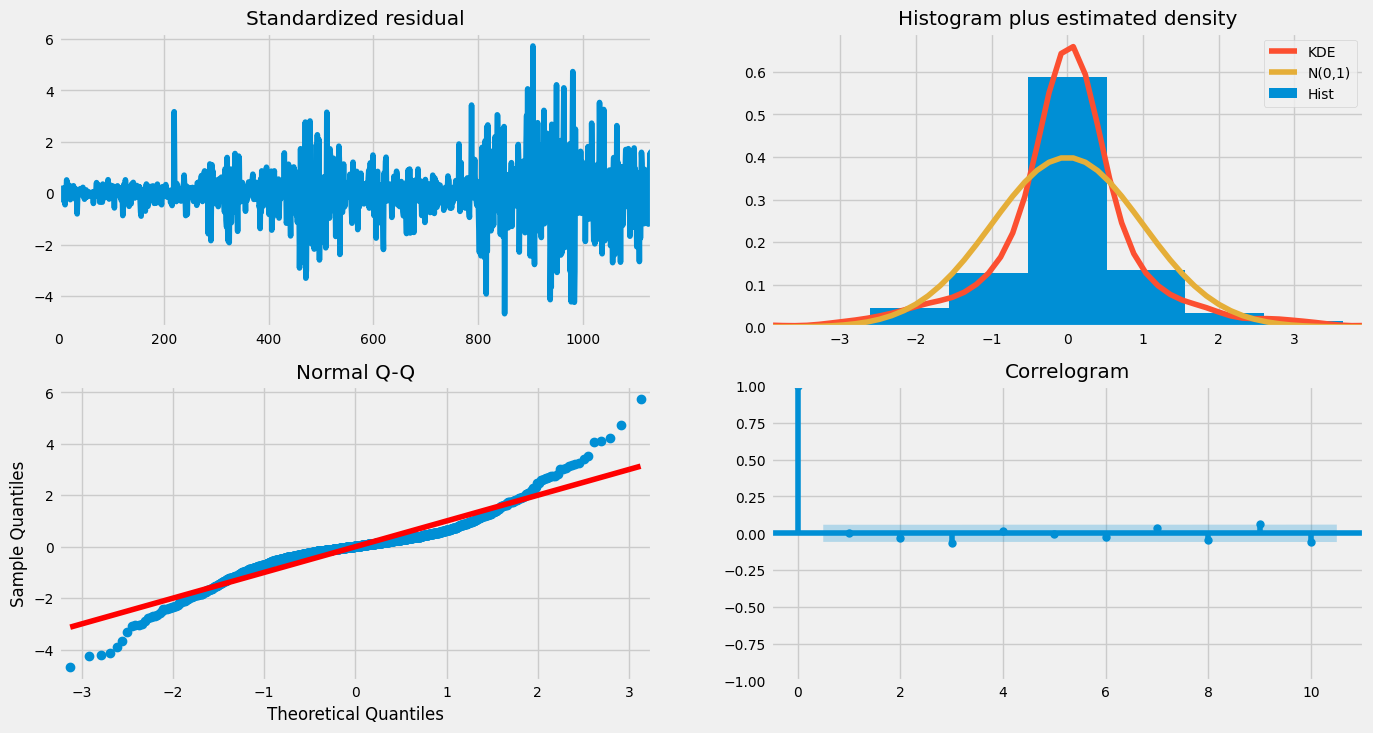

In [27]:
automodel.plot_diagnostics(figsize=(15,8))
plt.show()

#### Testing:

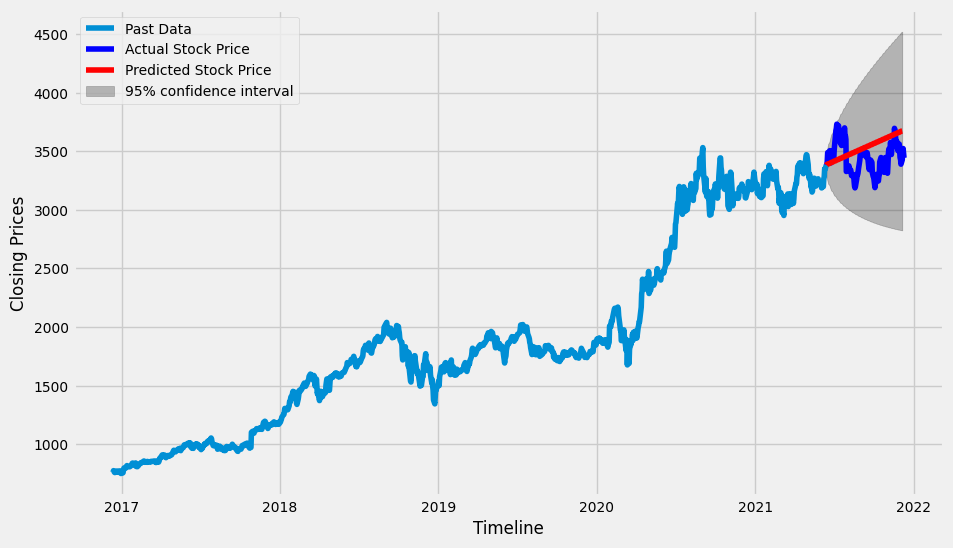

In [28]:
plot_arima(126, train_data, automodel, test_series=test_data)

#### Model Performance:

In [29]:
score_arima(len(test_data), test_data, automodel)

MSE: 33832.93971579712 (3383293.97%)
MAE: 160.4473770674018 (16044.74%)
RMSE: 183.93732551006912 (18393.73%)
MAPE: 0.042663554309648674 (4.27%)


Around 4.3% MAPE(Mean Absolute Percentage Error) implies the model is about 95.7% accurate in predicting the test set observations.

### Price Forecasting:

Using the above fitted model, now we can forecast the stock price for next month (30 Business days)

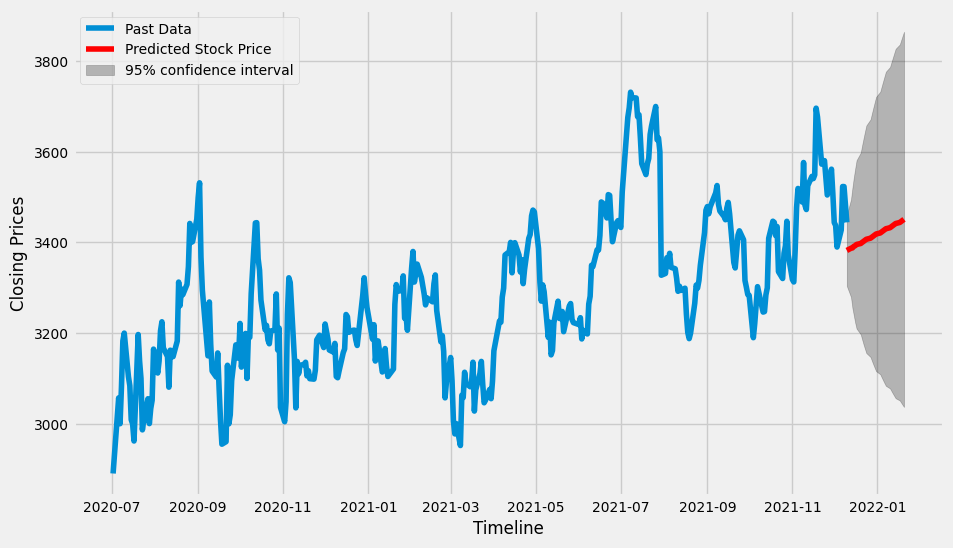

In [30]:
plot_arima(30, df_close, automodel, past_periods=365)

#### Appendix:

In [31]:
def closeprice_data(company_symbol):
    tbl_close = query_table(f"""SELECT Date, Close FROM HistoricalPrices 
        WHERE StockSymbol='{company_symbol}' """)

    df_close = pd.DataFrame(tbl_close, columns = ['Date','Close'])
    df_close['Date'] = pd.to_datetime(df_close['Date'])
    df_close.set_index('Date', inplace=True)
    #display(df_close)
    return (df_close)

In [32]:
def generalized_arima(n_periods, symbol, past_days=None):
    timeseries = closeprice_data(symbol)
    glamodel = arimamodel(timeseries)
    plot_arima(n_periods, timeseries, glamodel, past_periods=past_days)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9150.516, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9156.783, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9148.520, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9148.615, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9157.027, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9150.518, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9152.519, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9149.202, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.570 seconds


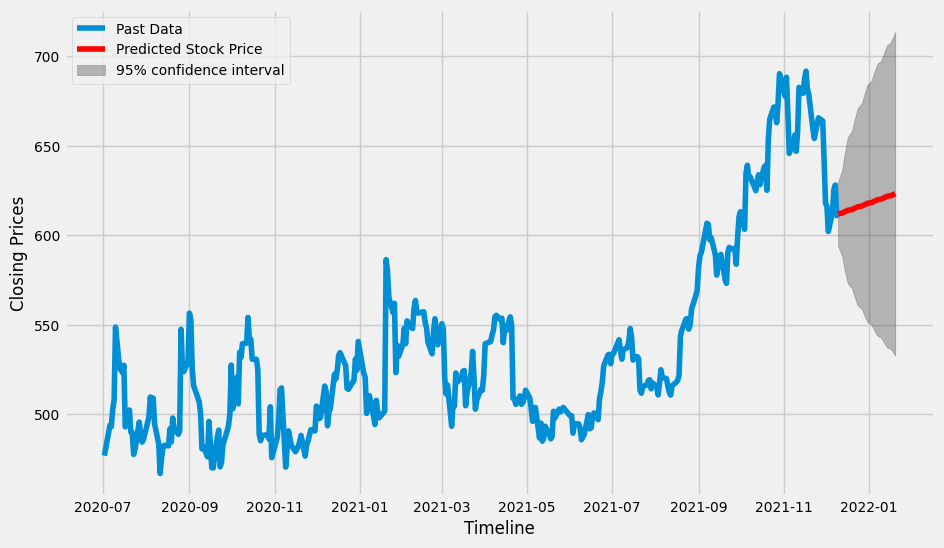

In [33]:
generalized_arima(30, 'NFLX', past_days=365)